# Data Augmentation #
- - - - 
* Data augmentation is the collection of techniques involved in generating new training samples.
* They must be generated  in a way such that the **class labels remain unchanged**.
* This improves the generalizability of the model.
* The validation accuracy is most likely going to increase at the cost of training accuracy.
- - - - 
![Me and the Boys](graphs/graph_1.png)
In image processing, data augmentation becomes very natural. Geometric transformations and adding random jitters and perturbations to pixel values give us new training samples with the same class label.
* Translations
* Rotations
* Changes in scale
* Horizontal flips
![Me and the Boys](memes/meme_1.jpg)


## Imports

In [58]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense
from keras.layers import Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import os
print(os.listdir("dataset"))

['flowers17_testing.csv', 'flowers17_training.csv']


## Load Data

In [3]:
train_df = pd.read_csv("dataset/flowers17_training.csv", header=None)
test_df = pd.read_csv("dataset/flowers17_testing.csv", header=None)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288
0,snowdrop,5,5,30,9,11,33,1,0,14,...,76,47,62,88,40,43,66,62,93,90
1,windflower,51,63,51,27,39,27,14,25,17,...,127,129,161,126,116,155,113,99,143,95
2,tigerlily,202,221,208,70,97,97,152,169,174,...,81,24,93,39,4,34,16,60,146,81
3,tigerlily,15,27,16,15,26,9,2,21,2,...,4,3,16,0,4,18,0,17,24,15
4,windflower,6,10,11,6,10,11,6,10,11,...,0,0,4,3,0,49,35,1,9,5


### Distribution of training data

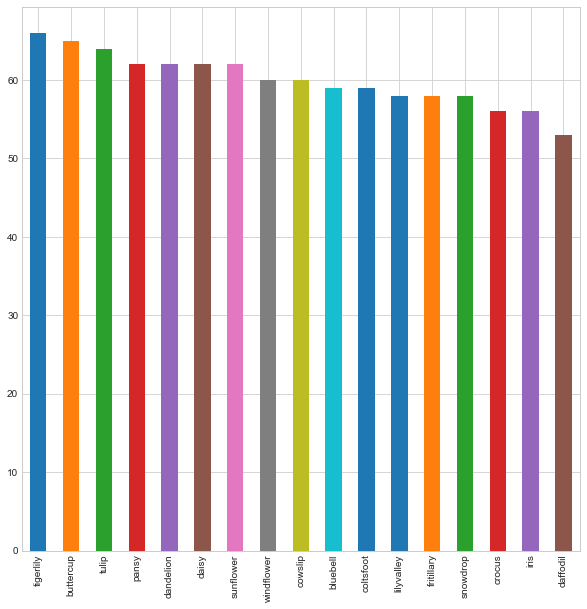

In [14]:
plt.figure(figsize=(10,10))
train_df[0].value_counts().plot(kind='bar');

### Distribution of test data

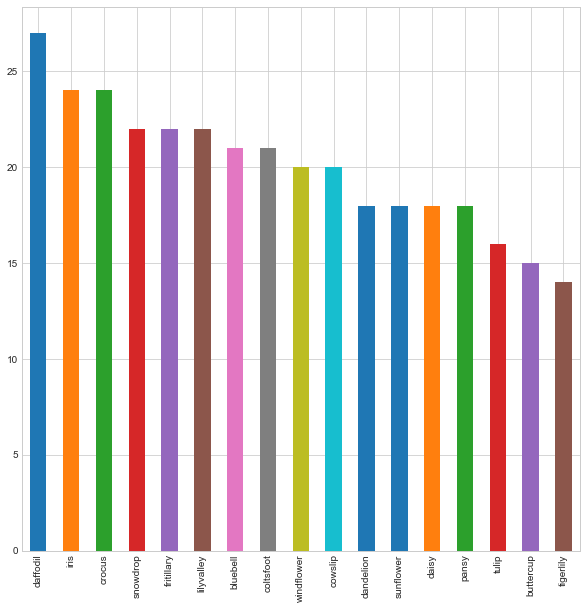

In [15]:
plt.figure(figsize=(10,10))
test_df[0].value_counts().plot(kind='bar');

## train and test data

In [16]:
y_train = train_df[0]
X_train = train_df.drop(columns=[0])
y_test = test_df[0]
X_test = test_df.drop(columns=[0])

## Visualize Data

In [18]:
def get_sample_images(X_train, y_train):
    image_data = []
    labels = []
    print("Loading images for: ", end =" ")
    samples = np.random.choice(len(X_train), 16)
    for sample in samples:
        print("{} |".format(y_train.iloc[sample]), end=" ")
        img = X_train.iloc[sample].values.reshape((64,64,3))
        img = np.flip(img, 2)
        image_data.append(img)
        labels.append(y_train.iloc[sample])
        
    return np.array(image_data), labels

In [19]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: print('Serial title'); titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, cmap=None)
        a.set_title(title, fontsize=50)
        a.grid(False)
        a.axis("off")
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [20]:
images, labels = get_sample_images(X_train, y_train)

Loading images for:  buttercup | windflower | cowslip | iris | daisy | fritillary | snowdrop | lilyvalley | buttercup | sunflower | bluebell | snowdrop | dandelion | crocus | pansy | crocus | 

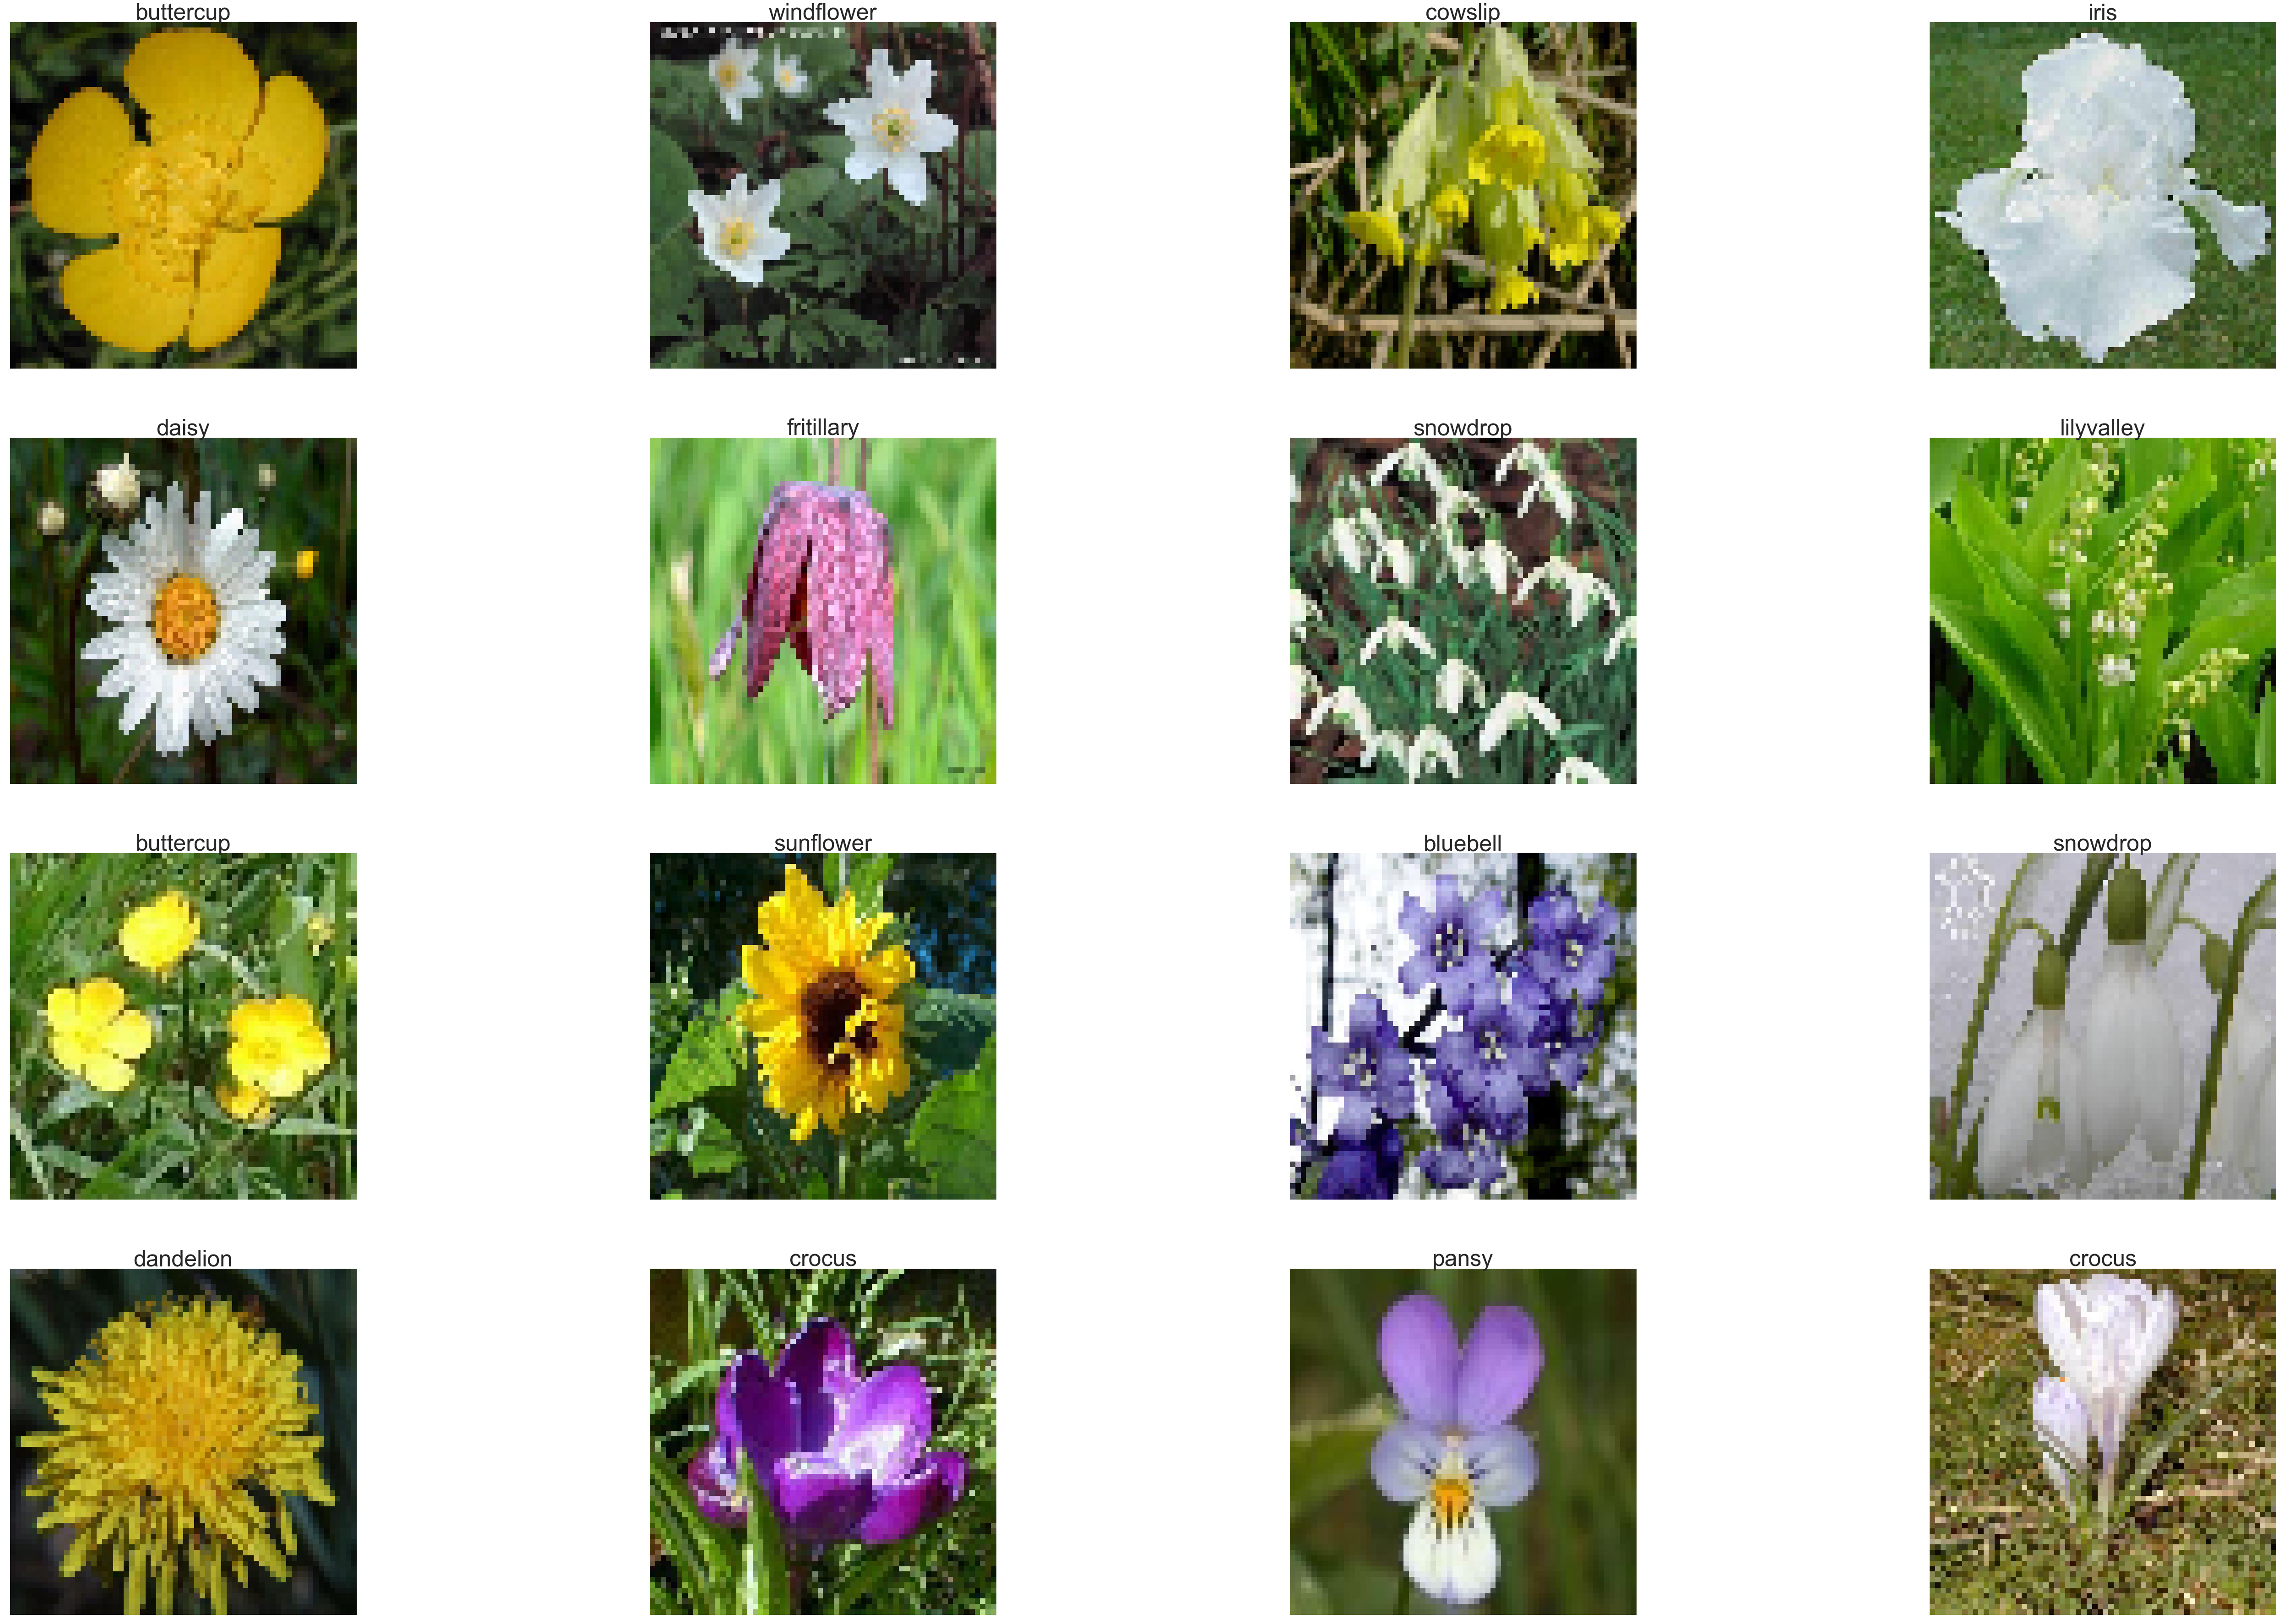

In [21]:
show_images(images, 4, titles=labels)

## Prepare Data

In [29]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

C:\Users\Ayush\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Ayush\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [51]:
X_train = np.flip(X_train.reshape((X_train.shape[0], 64,64,3)),3)
X_test = np.flip(X_test.reshape((X_test.shape[0], 64, 64, 3)),3)

## Model

In [52]:
def modelCNN(inputShape, classes):    
    inputX = Input(inputShape)

    l1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputX)
    l1 = Conv2D(32, (3, 3), padding="same", activation='relu')(l1)
    l1 = MaxPool2D(pool_size=(2, 2))(l1)
#     l1 = Dropout(0.25)(l1)

    # second CONV => RELU => CONV => RELU => POOL layer set
    l2 = Conv2D(64, (3, 3), padding="same", activation='relu')(l1)
    l2 = Conv2D(64, (3, 3), padding="same", activation='relu')(l2)
    l2 = MaxPool2D(pool_size=(2, 2))(l2)
#     l2 = Dropout(0.25)(l2)

    # third CONV => RELU => CONV => RELU => POOL layer set
    l3 = Conv2D(128, (3, 3), padding="same", activation='relu')(l2)
    l3 = Conv2D(128, (3, 3), padding="same", activation='relu')(l3)
    l3 = MaxPool2D(pool_size=(2, 2))(l3)
#     l3 = Dropout(0.25)(l3)

    # forth CONV => RELU => CONV => RELU => POOL layer set
    l4 = Conv2D(512, (3, 3), padding="same", activation='relu')(l3)
    l4 = Conv2D(512, (3, 3), padding="same", activation='relu')(l4)
    l4 = MaxPool2D(pool_size=(2, 2))(l4)

    # first (and only) set of FC => RELU layers
    l5 = Flatten()(l4)
    l5 = Dropout(0.5)(l5)
    l5 = Dense(512, activation="relu")(l5)

    # softmax classifier
    predictions = Dense(classes, activation="softmax")(l5)
    
    modelCNN = Model(inputs=inputX, outputs=predictions)
    
    return modelCNN

In [53]:
model = modelCNN((64,64,3), 17)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [55]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [56]:
earlyStopper = EarlyStopping(monitor='acc', patience=1, restore_best_weights=True)

In [57]:
hist = model.fit(X_train, y_train, batch_size=32,validation_data=(X_test, y_test), epochs=5)

Instructions for updating:
Use tf.cast instead.
Train on 1020 samples, validate on 340 samples
Epoch 1/5
1020/1020 [==============================] - 40s 39ms/step - loss: 2.8262 - acc: 0.0647 - val_loss: 2.8197 - val_acc: 0.0529
Epoch 2/5
1020/1020 [==============================] - 34s 33ms/step - loss: 2.5956 - acc: 0.1167 - val_loss: 2.4441 - val_acc: 0.1441
Epoch 3/5
1020/1020 [==============================] - 34s 33ms/step - loss: 2.2373 - acc: 0.1892 - val_loss: 2.2906 - val_acc: 0.1588
Epoch 4/5
1020/1020 [==============================] - 34s 33ms/step - loss: 1.9332 - acc: 0.3275 - val_loss: 1.8694 - val_acc: 0.3147
Epoch 5/5
1020/1020 [==============================] - 34s 33ms/step - loss: 1.7054 - acc: 0.4049 - val_loss: 1.7325 - val_acc: 0.3824


In [60]:
K.clear_session()

In [61]:
model = modelCNN((64,64,3), 17)

In [63]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

## ImageDataGenerator

In [64]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
                         shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [65]:
trainGenerator = aug.flow(X_train, y_train, batch_size=32)

In [66]:
testGenerator = aug.flow(X_test, y_test, batch_size=32)

In [67]:
hist = model.fit_generator(trainGenerator, validation_data=testGenerator,
                          steps_per_epoch=len(X_train) // 32, validation_steps=len(X_test)//32, epochs=5)

Epoch 1/5
31/31 [==============================] - 36s 1s/step - loss: 2.7852 - acc: 0.0565 - val_loss: 2.7152 - val_acc: 0.1344
Epoch 2/5
31/31 [==============================] - 33s 1s/step - loss: 2.5030 - acc: 0.1115 - val_loss: 2.3381 - val_acc: 0.1396
Epoch 3/5
31/31 [==============================] - 32s 1s/step - loss: 2.3234 - acc: 0.1685 - val_loss: 2.2405 - val_acc: 0.2110
Epoch 4/5
31/31 [==============================] - 33s 1s/step - loss: 2.1656 - acc: 0.2310 - val_loss: 2.0392 - val_acc: 0.2857
Epoch 5/5
31/31 [==============================] - 32s 1s/step - loss: 2.0410 - acc: 0.2355 - val_loss: 1.9886 - val_acc: 0.2597


### Save augmented images

In [69]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
                         shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [70]:
trainGenerator = aug.flow(X_train, y_train, batch_size=32, save_to_dir='dataset')

In [71]:
hist = model.fit_generator(trainGenerator, validation_data=testGenerator,
                          steps_per_epoch=len(X_train) // 32, validation_steps=len(X_test)//32, epochs=1)

Epoch 1/1
31/31 [==============================] - 36s 1s/step - loss: 1.9485 - acc: 0.2752 - val_loss: 2.0338 - val_acc: 0.2792
